# Linear Auto Encoder

Using Python and Numpy, write a class named LinearAutoEncoder with necessary methods, which implements a linear autoencoder. 

In [147]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
class LinearAutoEncoder:
    def __init__(self, hiddenSize, learningRate, max_loop, lambda_):
        # Initialization of the MLP model with given parameters
        self.hiddenNum = len(hiddenSize)
        self.hiddenSize = hiddenSize
        self.learningRate = learningRate
        self.max_loop = max_loop
        self.X = None
        self.Y = None
        self.w = None
        self.v = None
        self.hidw = None
        self.y_pred = None
        self.lambda_ = lambda_
    
    def sigmoid(self, z):
        # Sigmoid activation function
        return 1 / (1 + np.exp(-z))
    
    def ReLu(self, x):
        # Rectified Linear Unit (ReLU) activation function
        temp = x <= 0
        x[temp] = 0
        return x
    
    def relu_derivative(self, y):
        # Derivative of ReLU activation function
        return np.where(y > 0, 1.0, 0.0)

    def preprocess(self, X, Y):
        # Preprocessing of input data
        np.random.seed(1)
        X = np.insert(X, 0, 1, axis=1)
        self.X = X
        self.Y = Y
        # He initialization for the first hidden layer
        # self.v = np.random.randn(self.hiddenSize[0], self.X.shape[1] - 1) * np.sqrt(2. / (self.X.shape[1] - 1))
        self.v= np.random.rand(self.hiddenSize[0], self.X.shape[1] - 1)
        self.v = np.insert(self.v, 0, 0, axis=1)
        # Xavier initialization for the outer layer
        self.w = np.random.rand(self.Y.shape[1], self.hiddenSize[-1])
        self.w = np.insert(self.w, 0, 0, axis=1)
        self.hidw = []
        # He initialization for subsequent hidden layers
        for i in range(1, self.hiddenNum):
            # hw = np.random.randn(self.hiddenSize[i], self.hiddenSize[i - 1]) * np.sqrt(2. / (self.hiddenSize[i - 1]))
            hw=np.random.rand(self.hiddenSize[i], self.hiddenSize[i - 1])
            hw = np.insert(hw, 0, 0, axis=1)
            self.hidw.append(hw)
            
    def forward(self):
        # Forward propagation through the MLP
        self.h = []
        for i in range(self.hiddenNum):
            if i == 0:
                h = self.ReLu(np.dot(self.X, self.v.T))
                self.h.append(h)
            else:
                h = self.ReLu(np.dot(np.insert(self.h[i - 1], 0, 1, axis=1), self.hidw[i - 1].T))
                self.h.append(h)
        self.y_pred = np.dot(np.insert(self.h[-1], 0, 1, axis=1), self.w.T)
        
    def loss(self):
        # Calculate the loss function
        total_err= np.sum(np.square(self.y_pred - self.Y)) / 2
        l2_regularization = (self.lambda_ / 2) * (
            np.sum(np.square(self.v)) + np.sum(np.square(self.w)) + sum([np.sum(np.square(hw)) for hw in self.hidw])
        )
        total_err += l2_regularization
        return total_err
    
    def gradient(self):
        # Compute the gradients for backpropagation
        err = self.y_pred - self.Y
        self.grad_w = np.dot(np.insert(self.h[-1], 0, 1, axis=1).T, err).T
        self.grad_hidw = []
        if self.hiddenNum == 1:
            grad_h = np.dot(err , self.w[:, 1:])
            grad_z = self.relu_derivative(self.h[0])
            self.grad_v = np.dot(self.X.T, grad_h * grad_z).T
        else:
            for i in range(self.hiddenNum - 1, 0, -1):
                if i == self.hiddenNum - 1:
                    grad_h = np.dot(err, self.w[:, 1:])
                else:
                    grad_h = np.dot(grad_h_0, self.hidw[i][:, 1:])
                grad_z = self.relu_derivative(self.h[i])
                grad_hidw = np.dot(np.insert(self.h[i - 1], 0, 1, axis=1).T, grad_h * grad_z).T
                self.grad_hidw.append(grad_hidw)
                grad_h_0 = grad_h
            grad_h = np.dot(grad_h_0, self.hidw[0][:, 1:])
            grad_z = self.relu_derivative(self.h[0])
            self.grad_v = np.dot(self.X.T, grad_h * grad_z).T
        # L2 regularization
        self.grad_w += self.lambda_ * self.w
        self.grad_v += self.lambda_ * self.v
        for i in range(len(self.hidw)):
            self.grad_hidw[i] += self.lambda_ * self.hidw[-1 - i]
            
    def train(self):
        # Training the MLP using gradient descent
        mse_values = []  # List to store MSE values for each iteration
        for _ in range(self.max_loop + 1):
            self.forward()
            self.gradient()
            self.w = self.w - self.learningRate * self.grad_w
            for i in range(len(self.hidw)):
                self.hidw[i] = self.hidw[i] - self.learningRate * self.grad_hidw[-1 - i]
            self.v = self.v - self.learningRate * self.grad_v
            if _ % 1 == 0:
                print("Epoch: ", _, " MSE: ", self.loss())
                mse = self.loss()
                mse_values.append(mse)
        plt.plot(range(0, self.max_loop + 1, 1), mse_values)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        title = 'Epoch-MSE Graph, learning rate = ' + str(self.learningRate) + r', $\alpha$=' + str(self.lambda_)
        plt.title(title)
        plt.grid(True)
        plt.show()
        
    def predict(self, X):
        # Make predictions using the trained model
        X = np.insert(X, 0, 1, axis=1)
        h = []
        for i in range(self.hiddenNum):
            if i == 0:
                h.append(self.ReLu(np.dot(X, self.v.T)))
            else:
                h.append(self.ReLu(np.dot(np.insert(h[i - 1], 0, 1, axis=1), self.hidw[i - 1].T)))
        y_pred = np.dot(np.insert(h[-1], 0, 1, axis=1), self.w.T)
        return y_pred

Epoch:  0  MSE:  1.430984313407558e+17
Epoch:  1  MSE:  9.158419518001994e+16
Epoch:  2  MSE:  3663367807200796.0
Epoch:  3  MSE:  146534712288031.78
Epoch:  4  MSE:  5861388491521.27
Epoch:  5  MSE:  234455539660.85065
Epoch:  6  MSE:  9378221586.434023
Epoch:  7  MSE:  375128863.45736074
Epoch:  8  MSE:  15005154.538294422
Epoch:  9  MSE:  600206.1815317766
Epoch:  10  MSE:  24008.247261271055
Epoch:  11  MSE:  960.3298904508417
Epoch:  12  MSE:  38.41319561803368
Epoch:  13  MSE:  1.5365278247213505
Epoch:  14  MSE:  0.06146111298885197
Epoch:  15  MSE:  0.002458444519554197
Epoch:  16  MSE:  9.833778078223779e-05
Epoch:  17  MSE:  3.933511231290456e-06
Epoch:  18  MSE:  1.5734044925193883e-07
Epoch:  19  MSE:  6.293617969538101e-09
Epoch:  20  MSE:  2.517447186987065e-10
Epoch:  21  MSE:  1.0069788723301978e-11
Epoch:  22  MSE:  4.027915374257281e-13
Epoch:  23  MSE:  1.6111662624674144e-14
Epoch:  24  MSE:  6.444663748941484e-16
Epoch:  25  MSE:  2.577860649667877e-17
Epoch:  26  

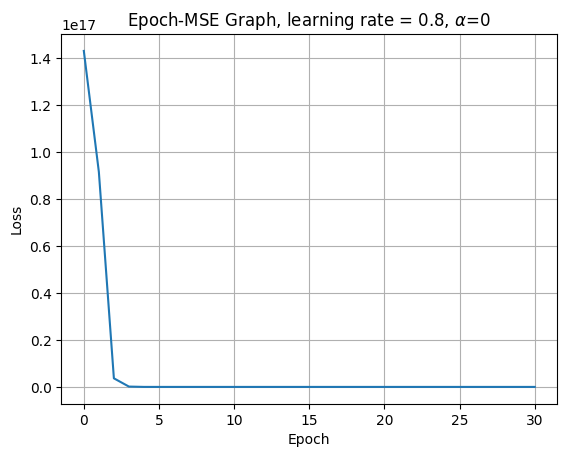

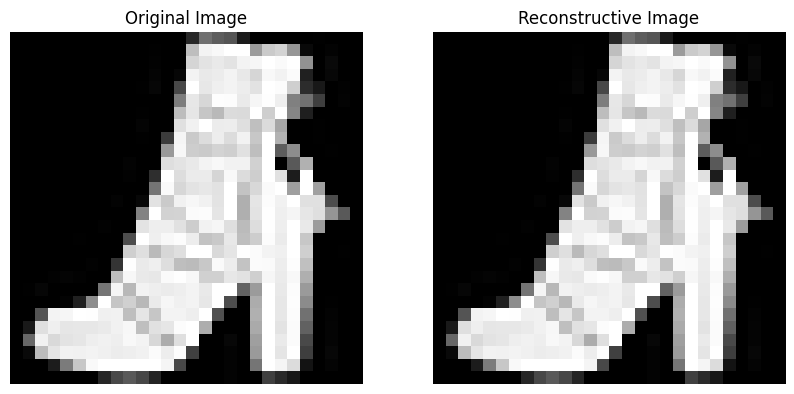

In [151]:
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt

# 重新加载Fashion MNIST数据集
(x_train, _), (_, _) = fashion_mnist.load_data()

# 显示第一张图片
sample_image = x_train[11]
x=np.array([sample_image.ravel()])
model0=LinearAutoEncoder([20,10,20], 0.8, 30, 0)
model0.preprocess(x, x)
model0.train()
y_pred = model0.predict(x)
y_pred.astype(int)
y_pred=y_pred.reshape(28,28)
_, axes = plt.subplots(1, 2, figsize=(10, 5))
# 显示图像1
axes[0].imshow(sample_image,cmap='gray')
axes[0].axis('off')
axes[0].set_title('Original Image')

# 显示图像2
axes[1].imshow(y_pred,cmap='gray',vmin=0,vmax=255)
axes[1].axis('off')
axes[1].set_title('Reconstructive Image')

plt.show()

Epoch:  0  MSE:  1.7327701149825314e+16
Epoch:  1  MSE:  1.1089874766476812e+16
Epoch:  2  MSE:  443594990659072.25
Epoch:  3  MSE:  17743799626362.883
Epoch:  4  MSE:  709751985054.515
Epoch:  5  MSE:  28390079402.180588
Epoch:  6  MSE:  1135603176.087223
Epoch:  7  MSE:  45424127.043488905
Epoch:  8  MSE:  1816965.0817395553
Epoch:  9  MSE:  72678.60326958219
Epoch:  10  MSE:  2907.1441307832865
Epoch:  11  MSE:  116.28576523133145
Epoch:  12  MSE:  4.651430609253239
Epoch:  13  MSE:  0.1860572243701303
Epoch:  14  MSE:  0.007442288974805188
Epoch:  15  MSE:  0.0002976915589922844
Epoch:  16  MSE:  1.190766235970523e-05
Epoch:  17  MSE:  4.7630649438573986e-07
Epoch:  18  MSE:  1.9052259775052247e-08
Epoch:  19  MSE:  7.620903909822966e-10
Epoch:  20  MSE:  3.048361565165349e-11
Epoch:  21  MSE:  1.2193446278715231e-12
Epoch:  22  MSE:  4.877378509332474e-14
Epoch:  23  MSE:  1.9509516166903916e-15
Epoch:  24  MSE:  7.803807134466419e-17
Epoch:  25  MSE:  3.121519048304782e-18
Epoch:

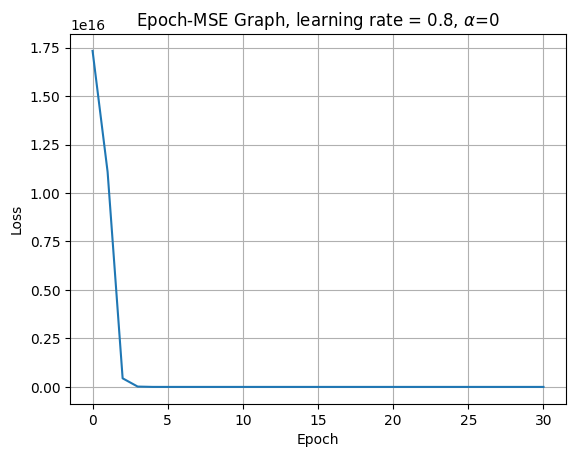

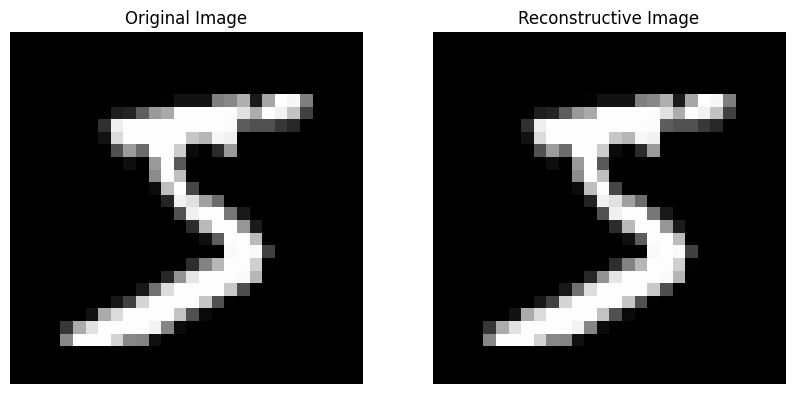

In [149]:
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# 重新加载Fashion MNIST数据集
(x_train, _), (_, _) = mnist.load_data()

# 显示第一张图片
sample_image = x_train[0]
x=np.array([sample_image.ravel()])
model1=LinearAutoEncoder([20,10,20], 0.8, 30, 0)
model1.preprocess(x, x)
model1.train()
y_pred = model1.predict(x)
y_pred.astype(int)
y_pred=y_pred.reshape(28,28)
_, axes = plt.subplots(1, 2, figsize=(10, 5))
# 显示图像1
axes[0].imshow(sample_image,cmap='gray')
axes[0].axis('off')
axes[0].set_title('Original Image')

# 显示图像2
axes[1].imshow(y_pred,cmap='gray',vmin=0,vmax=255)
axes[1].axis('off')
axes[1].set_title('Reconstructive Image')

plt.show()